<a href="https://www.kaggle.com/code/mustafacihadgoktepe/chest-x-ray-images-pneumonia-transfer-learning?scriptVersionId=108449825" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/'

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/'

val_datagen = ImageDataGenerator(rescale=1/255)

val_generator =  val_datagen.flow_from_directory(val_dir,
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 target_size=(150, 150))

test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                   batch_size=32,
                                                   class_mode='binary',
                                                   target_size=(150, 150))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


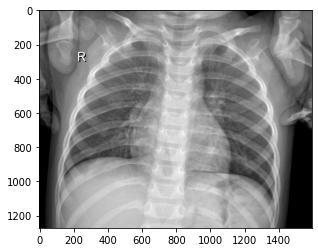

In [3]:
img_dir ='/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0219-0001.jpeg'
plt.imshow(plt.imread(img_dir), cmap='gray');

In [5]:
train_generator[0][0].shape

(32, 150, 150, 3)

In [6]:
train_generator[0][0][0].shape # image

(150, 150, 3)

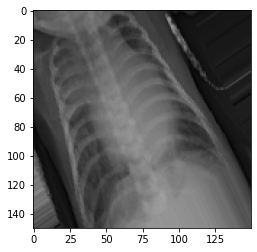

In [8]:
plt.imshow(train_generator[0][0][0]);

In [9]:
train_generator[0][1].shape

(32,)

In [10]:
train_generator[0][1][0] # label

1.0

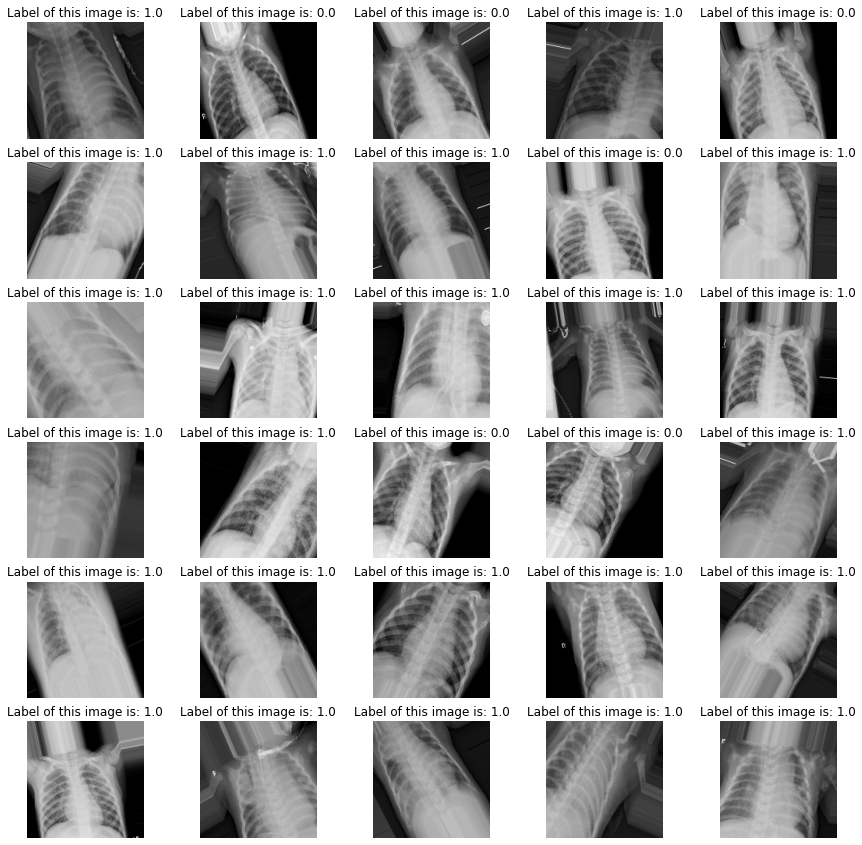

In [11]:
plt.figure(figsize=(15,15))
plt.tight_layout()

for i in range(30):
    plt.subplot(6,5,i+1)
    plt.axis('off')
    plt.title('Label of this image is: ' + str(train_generator[0][1][i]))
    plt.imshow(train_generator[0][0][i], cmap='gray')

In [12]:
from collections import Counter

counter = Counter(train_generator.classes)
counter

Counter({0: 1341, 1: 3875})

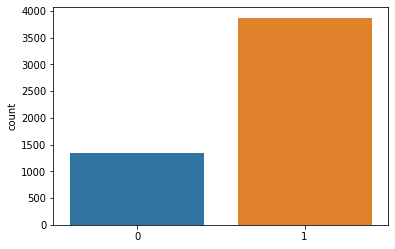

In [13]:
sns.countplot(train_generator.classes);

In [15]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, layers, callbacks, metrics, optimizers, losses

InceptionV3(input_shape=[150,150,3],weights='imagenet',include_top=False).trainable=False

model = Sequential([
    InceptionV3(input_shape=[150,150,3],weights='imagenet',include_top=False),
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer=optimizers.Adam(),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy(),
                       metrics.AUC(),
                       metrics.Precision(),
                       metrics.Recall()])
              
early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

lr_sch = callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience= 2, factor = np.sqrt(0.2), verbose = 1,
                                     min_lr = 5e-10)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
batch_normalization_282 (Bat (None, 3, 3, 2048)        14336     
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 147464    
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 21,964,593
Trainable params: 21,919,921
Non-trainable params: 44,672
_______________________________________

In [16]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes = np.unique(train_generator.classes),
                                                  y = train_generator.classes)

class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

In [18]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=20,
                    class_weight = class_weights,
                    callbacks=[early_stopping, lr_sch])

Epoch 1/20
163/163 [==============================] - 86s 525ms/step - loss: 0.4324 - binary_accuracy: 0.8704 - auc: 0.9255 - precision: 0.9492 - recall: 0.8723 - val_loss: 0.8769 - val_binary_accuracy: 0.5625 - val_auc: 0.7188 - val_precision: 0.6667 - val_recall: 0.2500
Epoch 2/20
163/163 [==============================] - 84s 516ms/step - loss: 0.3221 - binary_accuracy: 0.8834 - auc: 0.9422 - precision: 0.9534 - recall: 0.8865 - val_loss: 0.5677 - val_binary_accuracy: 0.6250 - val_auc: 0.7656 - val_precision: 0.5833 - val_recall: 0.8750
Epoch 3/20
163/163 [==============================] - 85s 524ms/step - loss: 0.2993 - binary_accuracy: 0.8919 - auc: 0.9495 - precision: 0.9534 - recall: 0.8983 - val_loss: 2.1247 - val_binary_accuracy: 0.7500 - val_auc: 0.7109 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 4/20
163/163 [==============================] - 85s 520ms/step - loss: 0.2866 - binary_accuracy: 0.9011 - auc: 0.9540 - precision: 0.9555 - recall: 0.9092 - val_loss: 0.8800 -

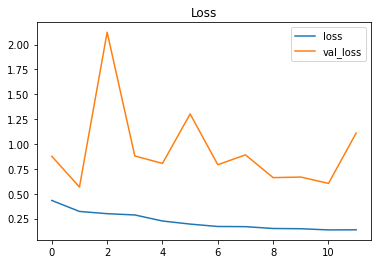

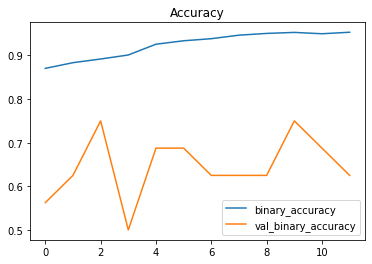

In [22]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss");
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy");

In [23]:
model.evaluate(test_generator)

20/20 [==============================] - 9s 457ms/step - loss: 0.4627 - binary_accuracy: 0.8301 - auc: 0.8518 - precision: 0.8447 - recall: 0.8923


[0.46274903416633606,
 0.8301281929016113,
 0.8518025279045105,
 0.844660222530365,
 0.892307698726654]

In [27]:
preds = model.predict(test_generator)
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1
pd.DataFrame(preds, columns=['Predictions'])

,Predictions
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
619,1.0
620,0.0
621,0.0
622,1.0


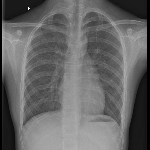

In [55]:
from keras.preprocessing import image

img_dir_ = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0073-0001.jpeg'
img_width, img_height = 150, 150

img = image.load_img(img_dir_, target_size = (img_width, img_height))
img

In [56]:
img = image.img_to_array(img)
img.shape

(150, 150, 3)

In [57]:
img = np.expand_dims(img, axis = 0)
img.shape

(1, 150, 150, 3)

In [58]:
pred_ = model.predict(img)
pred_

array([[0.5245365]], dtype=float32)